# Case Study: Modeling Bikeshare Usage

In this case study, we'll use regression techniques to study some of the factors that drive the usage of bikesharing systems. The data set for this case study was collected from the Capital Bikeshare system in Washington DC. We use the aggregated version graciously provided by the authors of the following paper: 

> Fanaee-T, Hadi, and Gama, Joao, "Event labeling combining ensemble detectors and background knowledge", Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg, doi:10.1007/s13748-013-0040-3.

This data set includes information about the season and time of year; the weather; and the count of bicycle users on each day for two years. This level of information gives us considerable ability to model phenomena in the data. 

In this case study, our primary aim will be **explanatory** modeling rather than **predictive** modeling. That is, we are more interested in learning something about the data we have than we are about predicting new, unseen data. To this end, we'll be prioritizing using a simple model with interpretable parameters. 

Some people would consider the emphasis on explanation vs. prediction to be the dividing line between *statistics* and *machine learning*, but in practice this is very fuzzy indeed. 

__Before we get started:__ Make sure the file bikeshare.csv is in the same folder as this notebook

In [1]:
#standard imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#read in the data
bikeshare = pd.read_csv("bikeshare.csv")


Okay, let's take a look

In [3]:
bikeshare

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


There are actually three columns we could aim to predict. *Casual* users don't sign up for the bikeshare service -- they just pay each time they decide to take a ride. In contrast, *registered* users pay a regular subscription fee. The `cnt` column is simply the sum of the casual and registered rides for each day. __For this case study, we will focus on modeling the behavior of casual riders.__ 

## Exploratory Analysis

Let's start by simply visualizing the total counts over time. For this, it helps to convert the `dteday` column into a proper `datetime` column.

In [4]:
import datetime
bikeshare['dteday']=pd.to_datetime(bikeshare['dteday'])

Now, let's make a simple plot

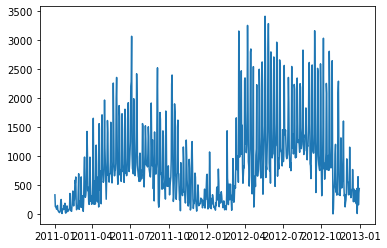

In [5]:
fig,ax=plt.subplots(1)
ax.plot(bikeshare['dteday'],bikeshare['casual'])

A few observations: 

- There seems to have been a slight overall increase in casual ridership over time. 
- There is a lot of variation in the data, with some days having very few riders and other days very many.  
- There's some seasonal variation -- for example, we see noticeable dips in winter. 

I wonder whether there's much of a difference between weekend vs. weekday ridership. 

In [6]:
bikeshare.groupby(['workingday'])[['casual']].mean()

,casual
workingday,
0,1371.134199
1,606.570000


More people use the bikeshare on the weekend! What if we breakdown by month?

In [7]:
bikeshare.groupby(['workingday','mnth'])[['casual']].mean()

casual
workingday mnth             
0          1      304.954545
           2      443.166667
           3     1229.647059
           4     1637.600000
           5     2137.263158
           6     2139.941176
           7     1901.428571
           8     1643.312500
           9     2056.750000
           10    1627.300000
           11    1045.700000
           12     504.047619
1          1      133.325000
           2      179.128205
           3      523.111111
           4      701.250000
           5      806.441860
           6      872.720930
           7      932.365854
           8      994.478261
           9      729.700000
           10     647.952381
           11     392.225000
           12     270.926829

This is kind of hard to read, let's make a plot!

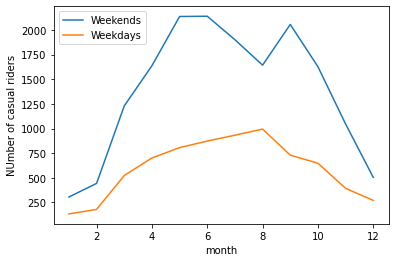

In [9]:
m=bikeshare.groupby(['workingday','mnth'])[['casual']].mean()

fig,ax=plt.subplots(1)
ax.plot(m.loc[0],label="Weekends")
ax.plot(m.loc[1],label="Weekdays")

ax.set(xlabel="month",ylabel="NUmber of casual riders")
ax.legend()

Ok, we're beginning to see some patterns now. There's a clear increase in casual ridership on the weekends, and in warmer months in the middle of the year. So, we'd expect these variables to play major roles in our modeling.

We can break things up further -- what's the dependence on the weather? 

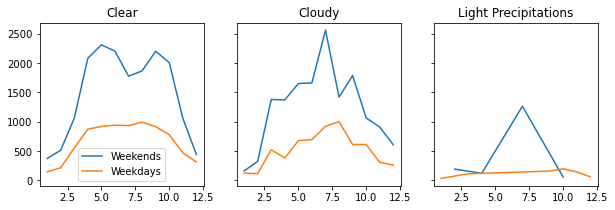

In [13]:
m=bikeshare.groupby(['workingday','weathersit','mnth'])[['casual']].mean()

fig,ax=plt.subplots(1,3,figsize=(10,3),sharey=True)

weather_codes={1:"Clear",
              2:"Cloudy",
              3:"Light Precipitations"}

for w in weather_codes.keys():
    ax[w-1].plot(m.loc[0].loc[w],label="Weekends")
    ax[w-1].plot(m.loc[1].loc[w],label="Weekdays")
    ax[w-1].set(title=weather_codes[w])
    
ax[0].legend()

Ok, this makes sense: cloudy weather doesn't seem to be much of a deterrent, but precipitation makes a major difference. 

## Data Prep

We've now learned quite a lot about what we're looking for, so let's go ahead and begin preparing our data for modeling. Let's first grab only the variables that we want to include as a new data frame. 

Note that we've excluded, for example, `season`, because all the information in the `season` column is actually already contained in the `mnth`. 

In [14]:
cols = ["casual", 
        "mnth", 
        "weathersit", 
        "workingday",
        "yr",
        "temp", 
        "hum", 
        "windspeed",
        "holiday"]

model_df=bikeshare[cols]

Next, we need to encode the `mnth` column in a way that an algorithm can understand. The easiest way is to use `pd.get_dummies()`, which will create a `0-1` column associated to each possible value. 

In [15]:
model_df=pd.get_dummies(model_df,columns=['mnth'])
model_df

,casual,weathersit,workingday,yr,temp,hum,windspeed,holiday,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12
0,331,2,0,0,0.344167,0.805833,0.160446,0,1,0,0,0,0,0,0,0,0,0,0,0
1,131,2,0,0,0.363478,0.696087,0.248539,0,1,0,0,0,0,0,0,0,0,0,0,0
2,120,1,1,0,0.196364,0.437273,0.248309,0,1,0,0,0,0,0,0,0,0,0,0,0
3,108,1,1,0,0.200000,0.590435,0.160296,0,1,0,0,0,0,0,0,0,0,0,0,0
4,82,1,1,0,0.226957,0.436957,0.186900,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,247,2,1,1,0.254167,0.652917,0.350133,0,0,0,0,0,0,0,0,0,0,0,0,1
727,644,2,1,1,0.253333,0.590000,0.155471,0,0,0,0,0,0,0,0,0,0,0,0,1
728,159,2,0,1,0.253333,0.752917,0.124383,0,0,0,0,0,0,0,0,0,0,0,0,1
729,364,1,0,1,0.255833,0.483333,0.350754,0,0,0,0,0,0,0,0,0,0,0,0,1


__Note:__ Using dummy variables like this is often called a one-hot encoding in the machine learning world.

Now we can separate our data into predictor and target variables. 

In [16]:
X=model_df.drop(['casual'],axis=1)
y=model_df['casual']

Model time! Because our interest is explanatory rather than predictive, we are just going to train and evaluate the model on the same set of data. There are still potential problems with doing this! In this particular case, however, we're not too worried about overfitting because the number of data points far outnumbers the number of model parameters.

In [17]:
from sklearn.linear_model import LinearRegression
LR=LinearRegression()
LR.fit(X,y)

LinearRegression()

In [18]:
LR.score(X,y)

0.7307281905763694

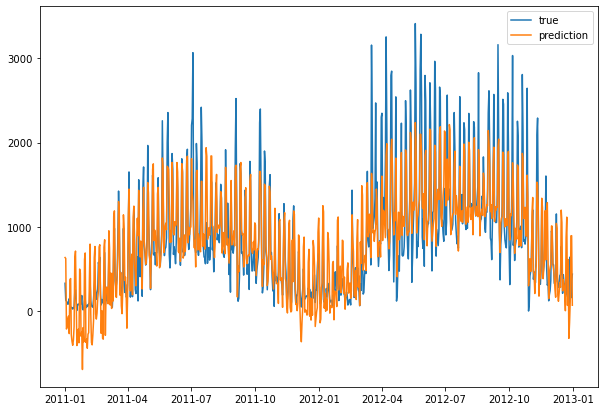

In [20]:
bikeshare['preds']=LR.predict(X)
fig,ax=plt.subplots(1,figsize=(10,7))

ax.plot(bikeshare['dteday'],bikeshare['casual'],label="true")
ax.plot(bikeshare['dteday'],bikeshare['preds'],label="prediction")

ax.legend()

Not bad! The model does a fair job of replicating the true data. The fit isn't perfect, in at least two ways. 

1. There are some visible discrepancies between the modeled and observed values. 
2. There are a few days on which the model predicts negative ridership, which obviously can't be correct. 

So, this model has room for improvement. Still, considering how simple it was to put together, it's a fair start! Recall that one of our main aims was to learn something about which conditions make a difference for ridership. Linear models are great for this, because we can just investigate the coefficients directly. 

In [21]:
pd.DataFrame({"variable:":X.columns,"coefficient":LR.coef_.round(2)})

,variable:,coefficient
0,weathersit,-113.62
1,workingday,-822.77
2,yr,287.47
3,temp,1615.43
4,hum,-550.08
5,windspeed,-1164.64
6,holiday,-299.52
7,mnth_1,-262.63
8,mnth_2,-275.11
9,mnth_3,87.13


Here's what we observe: 

1. Recall that higher values of the `weathersit` variable correspond to more severe weather. The negative coefficient indicates that, for each step up the severity scale, roughly 100 riders are lost. 
2. After controlling for the other variables, there are roughly 800 more riders on weekends than working days. Wow!
3. The `yr` coefficient accounts for the slight overall increase in riders over time: a day in year 1 might have nearly 300 more riders than a comparable day in year 0. 
4. Warm temperatures bring out the bicyclists! 
5. Similarly, no one likes humidity, or high winds. 
6. There tends to be a large drop in casual bicyclists on holidays. 

The various month results deserve special attention. Higher values indicate that, all else being equal, the model predicts more riders that month. However, we should be very cautious in interpreting these results, since certain months are likely to have lower temperatures or higher humidities, for example. So, it's not usually the case that "all else is equal." Still, these results do give us suggestive and potentially useful quantitative insights, such as rider's preferences for warmer months over colder ones, especially in the spring as the snow melts. 

## Next? 

Depending on our goals, we have many possible next steps. We might aim to improve our model accuracy by using more sophisticated models or collecting more data. We might aim to deploy more complex models in order to handle dependencies between the month variables and the weather variables, for example. Rather than the explanatory angle we've used here, we might instead choose to look at this problem through a predictive lens, and aim to predict the bikeshare usage in unseen, coming months. As usual in data science, each model opens at least as many doors as it closes. 

<figure class="image" style="width:100%">
  <img src="https://d33wubrfki0l68.cloudfront.net/795c039ba2520455d833b4034befc8cf360a70ba/558a5/diagrams/data-science-explore.png" alt="A diagram with the words import, tidy, transform, visualize, model, and communicate. Import points to tidy. Tidy points to transform. Transform points to visualize, visualize poitns to model, and model points to visualize, thus forming a directed cycle of arrows. This cycle collectively points to the final word, communicate." width="600px">
    <br>
    <caption><i>The cycle of data science. Image credit: Hadley Wickham</i></caption>
</figure>
